In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

final state points: 9030001.0 time step, 2 kT, status:job-computed
9e889aab2463152b3ec03bbe1ce25cce
total frames  90
final state points: 9030001.0 time step, 0.1 kT, status:job-computed
b0291a0de9d05fbdcd555324639f9462
total frames  90
final state points: 9030001.0 time step, 1 kT, status:job-computed
aee688bdfe142a01969002c8cf1dae71
total frames  90
final state points: 9030001.0 time step, 6 kT, status:job-computed
21d8f1661a833c40ad3ddcb95f296005
total frames  90
final state points: 9030001.0 time step, 4 kT, status:job-computed
956f1acc375c4c2cb7b8f0b644d99f8d
total frames  90


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


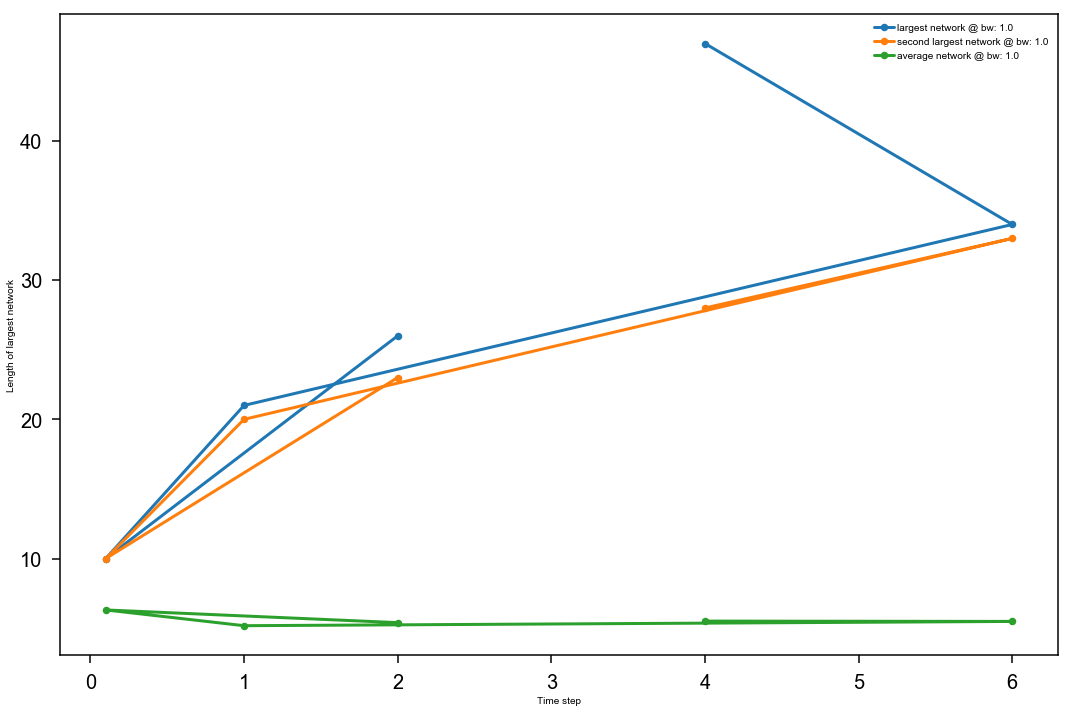

In [8]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', '../data/')


sbws = [1.0]
for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []
    fig, ax1 = plt.subplots(figsize=(15,10))
    
    jobs = project.find_jobs({'activation_energy':1.0})#, 'sec_bond_weight':sbw})
    for job in jobs:
        job_status = get_status(job)
        if job_status == 'job-computed' and job.sp.temp_prof[-1][0]==9030001.0:
            print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            print(job)
            kTs.append(job.sp.temp_prof[-1][1])
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            snapshot = t[last_frame]
            sim_box = snapshot.configuration.box
            fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
            bonds = snapshot.bonds.group
            G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
            G.graph
            for bond in bonds:
                G.add_edge(bond[0],bond[1])
            n_connected = nx.number_connected_components(G)
            largest_cc = max(nx.connected_components(G), key=len)
            connected_components.append(n_connected)
            largest_networks.append(len(largest_cc))
            sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
            second_largest_networks.append(sorted_cc[1])
            average_network_lens.append(np.mean(sorted_cc))
            
    ax1.plot(kTs, largest_networks,linestyle='-',marker='o',label='largest network @ bw: {}'.format(sbw))
    ax1.plot(kTs, second_largest_networks,linestyle='-',marker='o',label='second largest network @ bw: {}'.format(sbw))
    ax1.plot(kTs, average_network_lens,linestyle='-',marker='o',label='average network @ bw: {}'.format(sbw))
ax1.set_xlabel('Time step')
ax1.set_ylabel('Length of largest network')
#ax2.set_ylabel('Number of networks')
fig.tight_layout()
plt.legend()
plt.show()
